In [ ]:
!pip install pandas
!pip install torch torchvision
!pip install cython
!pip install matplotlib
!pip install opencv-python

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [ ]:
import torch.optim as optim
import pandas as pd
import torch
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torchvision.transforms as T

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms as T

class CustomCSVDetectionDataset(Dataset):
    def __init__(self, csv_file, images_dir, transforms=None):
        self.df = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.transforms = transforms
        self.image_ids = self.df['image_name'].unique()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records = self.df[self.df['image_name'] == image_id]

        image = Image.open(os.path.join(self.images_dir, image_id)).convert("RGB")
        boxes = []
        labels = []

        for _, row in records.iterrows():
            xmin = row['bbox_x']
            ymin = row['bbox_y']
            xmax = xmin + row['bbox_width']
            ymax = ymin + row['bbox_height']
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1 if row['label_name'] == 'Marine Animal' else 2)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id

        # Convert image to tensor if no transformations are applied
        if self.transforms:
            image = self.transforms(image)
        else:
            image = T.ToTensor()(image)

        return image, target

# Define paths
csv_file = '/content/drive/MyDrive/Dataset7.0/train/annotations/train_labels.csv'
images_dir = '/content/drive/MyDrive/Dataset7.0/train/images'

# Create dataset and dataloaders without transformations
dataset = CustomCSVDetectionDataset(csv_file, images_dir, transforms=None)

# DataLoader setup
def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Initialize the model
model = get_model(num_classes=3)  # 2 classes (marine animal, trash) + background
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Training loop
import torch.optim as optim

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 5

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 82.4MB/s]


In [ ]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Define the path to your model weights
model_path = '/content/drive/MyDrive/model_weights_epoch_53.pth'

# Initialize the model
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Create an instance of the model
model = get_model(num_classes=3)  # Replace 3 with the number of classes in your dataset

# Load the model weights onto CPU
device = torch.device('cpu')  # Specify the device (CPU in this case)
model.load_state_dict(torch.load(model_path, map_location=device))

# Set the model to evaluation mode
model.eval()

# Print a message indicating successful loading
print(f"Model loaded from {model_path}")


Model loaded from /content/drive/MyDrive/model_weights_epoch_53.pth


In [ ]:
"""
model_path = '/content/drive/MyDrive/model_weights_epoch_53.pth'
model.load_state_dict(torch.load(model_path))
model.eval()
print(f"Model loaded from {model_path}")
"""

'\nmodel_path = \'/content/drive/MyDrive/model_weights_epoch_53.pth\'\nmodel.load_state_dict(torch.load(model_path))\nmodel.eval()\nprint(f"Model loaded from {model_path}")\n'

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.ops import box_iou


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class_colors = {
    1: (255, 165, 0),  # Marine Animal - Orange
    2: (255, 255, 0)   # Trash - Yellow
}

class_names = {
    1: 'Marine Animal',
    2: 'Trash'
}

label_to_int = {
    'Marine Animal': 1,
    'Trash': 2
}

In [ ]:
def visualize_predictions(image, boxes, labels, scores, threshold=0.5):
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            box = box.astype(np.int32)
            color = class_colors.get(label, (255, 255, 255))
            label_name = class_names.get(label, 'Unknown')

            cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, 2)
            cv2.putText(image, f"{label_name}: {score:.2f}", (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


In [ ]:
def visualize_ground_truth(image, boxes, labels):
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    for box, label in zip(boxes, labels):
        box = box.astype(np.int32)
        color = class_colors.get(label, (255, 255, 255))
        label_name = class_names.get(label, 'Unknown')

        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, 2)
        cv2.putText(image, f"{label_name}", (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


In [ ]:
test_csv_file = '/content/drive/MyDrive/Dataset7.0/test/annotations/test_labels.csv'
test_images_dir = '/content/drive/MyDrive/Dataset7.0/test/images'
test_dataset = CustomCSVDetectionDataset(test_csv_file, test_images_dir)
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)


In [ ]:
class CustomCSVDetectionDataset(Dataset):
    def __init__(self, csv_file, images_dir, transforms=None):
        self.annotations = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.annotations['image_name'].unique())

    def __getitem__(self, idx):
        image_name = self.annotations['image_name'].unique()[idx]
        img_path = os.path.join(self.images_dir, image_name)
        image = Image.open(img_path).convert("RGB")

        boxes = self.annotations[self.annotations['image_name'] == image_name][['bbox_x', 'bbox_y', 'bbox_width', 'bbox_height']].values
        labels = self.annotations[self.annotations['image_name'] == image_name]['label_name']
        labels = labels.map(label_to_int).values

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

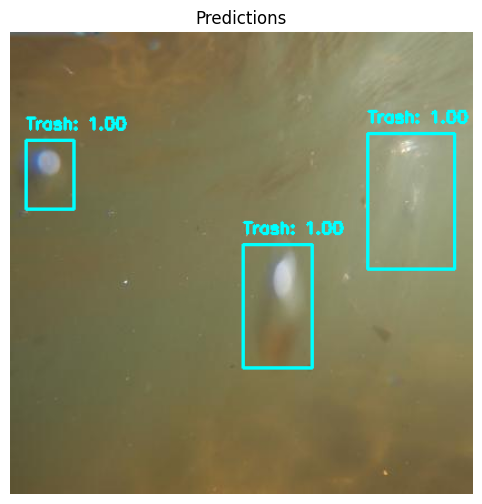

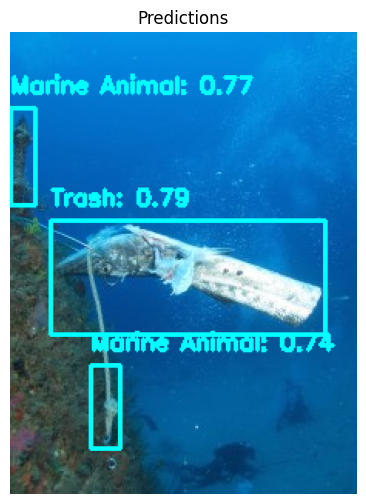

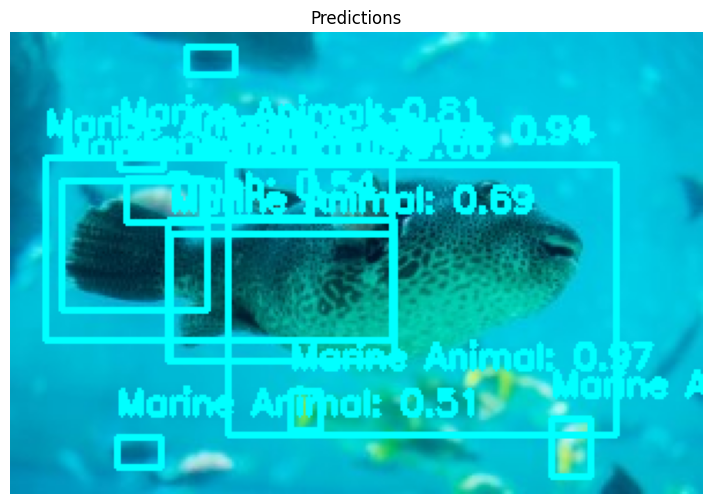

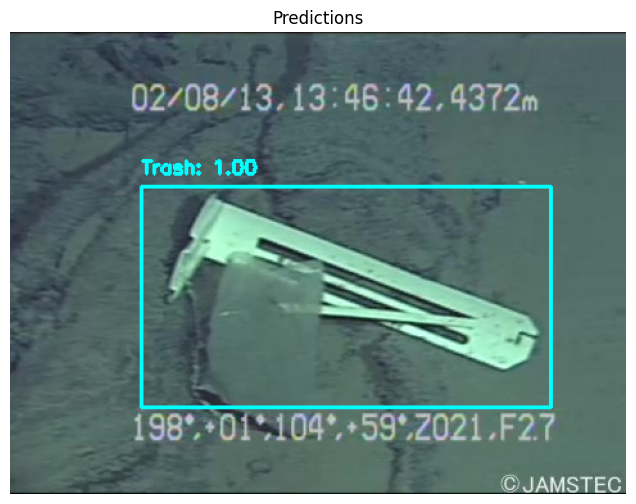

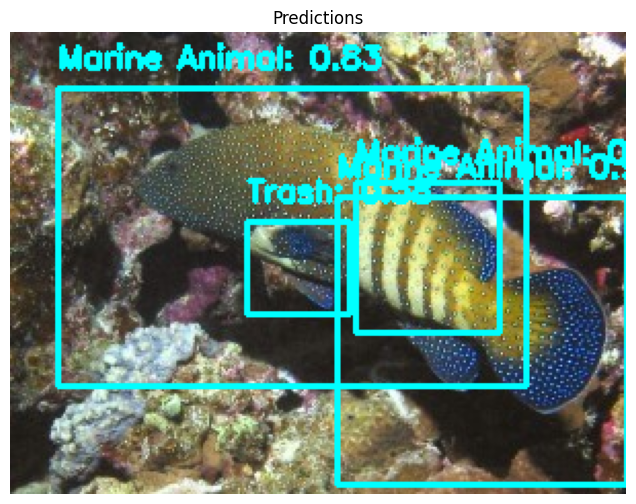

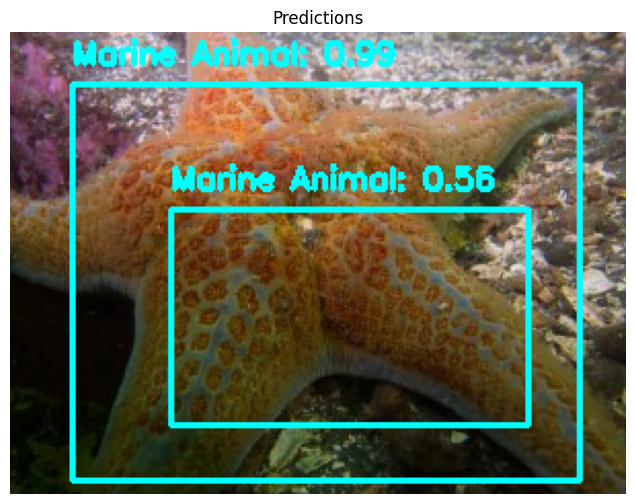

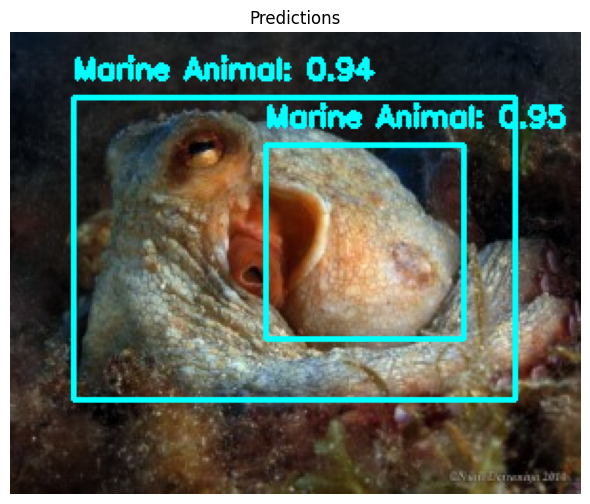

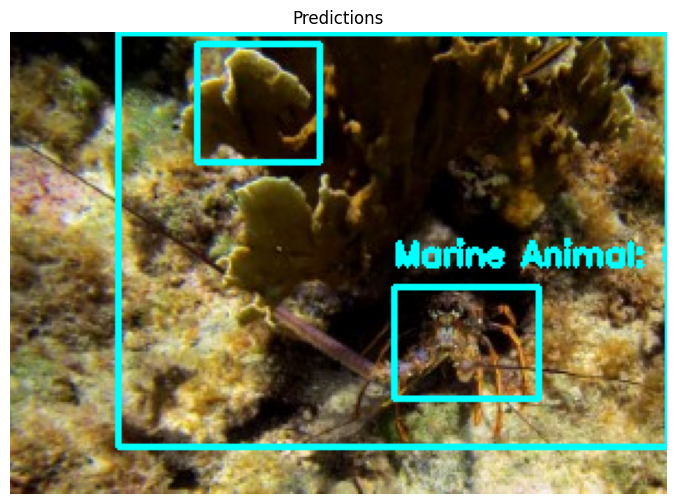

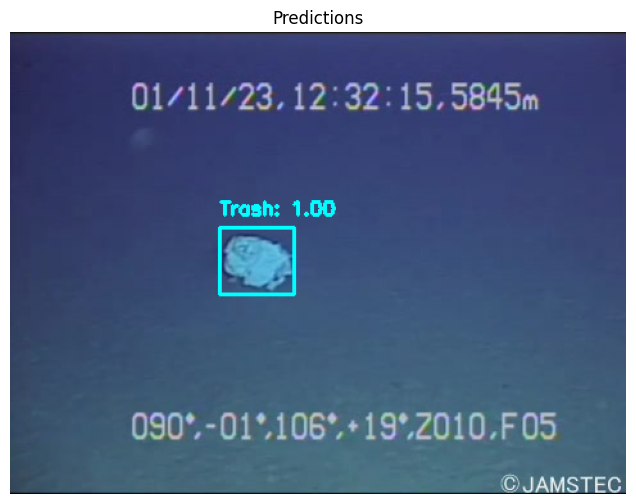

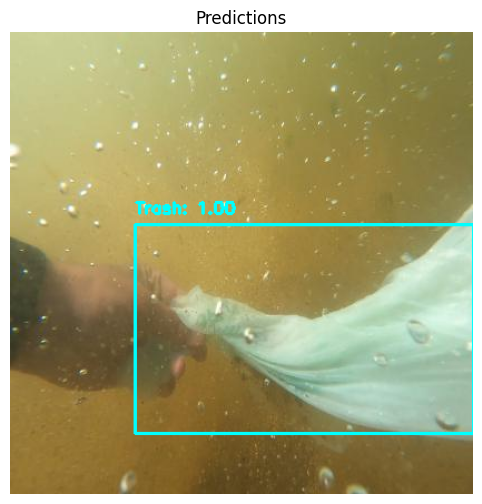

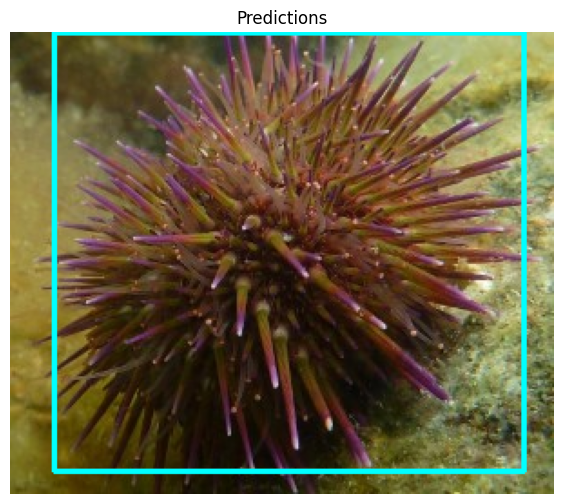

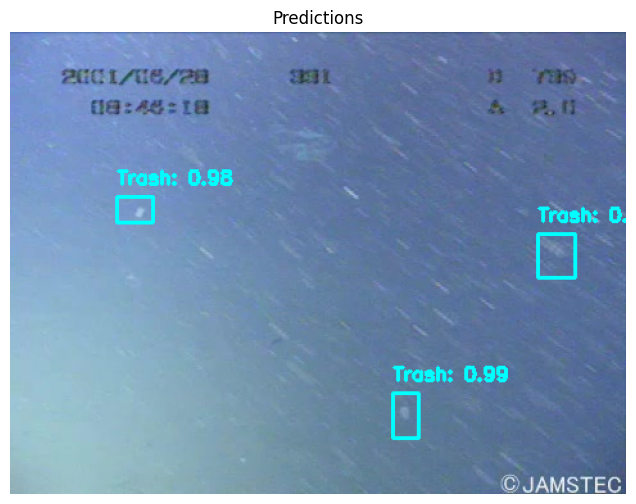

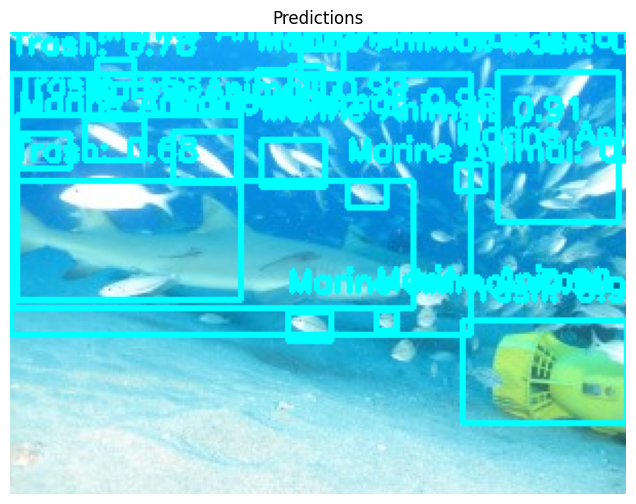

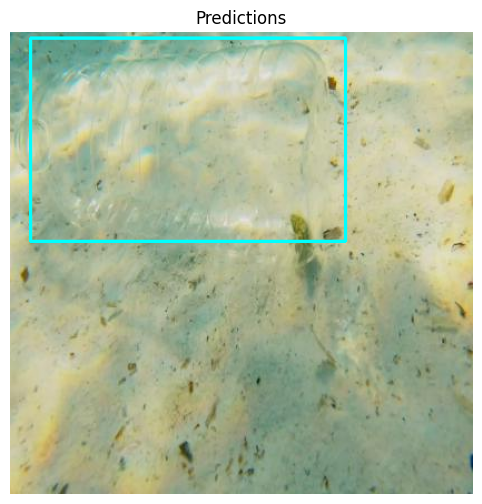

KeyboardInterrupt: 

In [ ]:
import torch
import matplotlib.pyplot as plt

for images, targets in test_data_loader:
    # Ensure images are tensors and move them to the device
    images = [image.to(device) if isinstance(image, torch.Tensor) else T.ToTensor()(image).to(device) for image in images]

    with torch.no_grad():
        outputs = model(images)

    for image, output in zip(images, outputs):
        image = image.cpu().permute(1, 2, 0).numpy()  # Convert tensor to numpy array for visualization

        pred_boxes = output['boxes'].cpu().numpy()
        pred_labels = output['labels'].cpu().numpy()
        pred_scores = output['scores'].cpu().numpy()

        pred_image = visualize_predictions(image, pred_boxes, pred_labels, pred_scores)

        # Plot predictions
        plt.figure(figsize=(12, 6))
        plt.imshow(pred_image)
        plt.title('Predictions')
        plt.axis('off')
        plt.show()
